In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

In [2]:
# Set random seed

# Call `set_seed` function to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')


# When `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = torch.device("cpu")
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

Random seed 2021 has been set.


In [4]:
def print_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)

In [5]:

class Experiment:

    def __init__(self):

        # Set the width and height of the grid
        self.width = 8
        self.height = 8
        
        self.Target_position_grid = np.eye(self.width,dtype=float)
        for i in range(self.width-1):
            self.Target_position_grid[i,i-1] = 1
            self.Target_position_grid[i,i+1] = 1
            
        self.Target_position_grid[self.width-1,self.width-1] = 1
        self.Target_position_grid[self.width-1,self.width - 2] = 1


    def data_generator(self):
        x = np.random.randint(0,7)
        y = np.random.randint(0,7)
 
        sun = np.random.random_sample()
        rain = np.random.random_sample()
        #data = torch.tensor([x/8,y/8,sun,rain])
        target = self.Target_position_grid[x,y]
        data = [x,y]      
        return data
    
    
    
    def Create_Dataset(self,SIZE,BATCH_SIZE):
        
        data = [self.data_generator() for i in range(SIZE)]
        target =[self.Target_position_grid[a[0],a[1]] for a in data]
        data, target = torch.tensor(data,dtype=torch.float32), torch.tensor(target,dtype=torch.float32)

        dataset = TensorDataset(data, target)
        train_dataset, val_dataset = random_split(dataset, [int(np.floor(0.8*SIZE)), int(np.floor(0.2*SIZE))])
        train_loader = DataLoader(dataset=train_dataset, 
                                  batch_size=BATCH_SIZE, 
                                  worker_init_fn=seed_worker,
                                  generator=g_seed)
        val_loader = DataLoader(dataset=val_dataset, 
                                batch_size=BATCH_SIZE, 
                                worker_init_fn=seed_worker,
                                generator=g_seed)

        return train_loader,val_loader


class Net_2(torch.nn.Module):
    def __init__(self,input_dimension, output_dimension):
        super(Net_2, self).__init__()
        self.fc1 = nn.Linear(in_features = input_dimension, out_features =1)
        self.fc2 = nn.Linear(in_features = 1, out_features = 2)
        #self.fc3 = nn.Linear(in_features = 5, out_features =5)
        #self.fc4 = nn.Linear(in_features = 5, out_features = 2)
        self.fc5 = nn.Linear(in_features = 2,  out_features = output_dimension)

        #self.mask2 = torch.tensor([[1,0],[1,0],[0,1],[0,1]])
        #self.mask3 = torch.tensor([[1,1,0,0],[0,0,1,1]]) 


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return torch.sigmoid(x)



class Training(Experiment):

  # The class initialisation function.
    def __init__(self,model,opti,loss):
        self.model = model
        self.optimizer = opti
        self.criterion = loss
    
    def train_network(self,data,target):
        Loss = []  
        #Compute the prediction
        output = self.model.forward(data)
        # Calculate the loss for this transition.
        loss =  self.criterion(output,target.unsqueeze(1))
        # Set all the gradients stored in the optimiser to zero.
        self.optimizer.zero_grad()
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        loss.backward()    
        # Take one gradient step to update the Q-network. 
        self.optimizer.step()
        # Return the loss as a scalar
        
        return loss


In [6]:
torch.manual_seed(42)

Size_total_dataset = 1000
Batch_size = 32
n_epochs = 500
learning_rate = 0.001


experiment = Experiment()
train_loader,val_loader = experiment.Create_Dataset(SIZE = Size_total_dataset,BATCH_SIZE = Batch_size)

2nd Network with 5 layers

Random seed 2021 has been set.

 The model parameters before the update are: 

fc1.weight tensor([[-0.5226,  0.0189]])
fc1.bias tensor([0.3430])
fc2.weight tensor([[0.4318],
        [0.1409]])
fc2.bias tensor([-0.6695, -0.9114])
fc5.weight tensor([[ 0.6545, -0.2909]])
fc5.bias tensor([-0.5669])
Size val_loader 7
Size train_loader 25


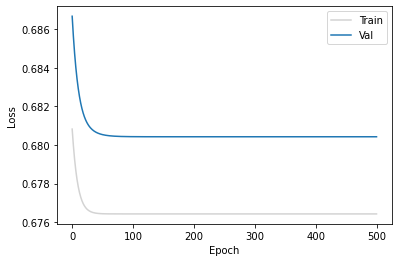

In [7]:
### MAIN ###
set_seed(seed=SEED)
model = Net_2(input_dimension = 2, output_dimension = 1)


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
experiment = Experiment()
train = Training(model,optimizer,criterion)

print('\n The model parameters before the update are: \n')
print_params(model)

print("Size val_loader",len(val_loader))
print("Size train_loader",len(train_loader))

losses = []
val_losses = []

for epoch in range(n_epochs):
    loss = 0
    val_loss = 0 
    for x_batch, y_batch in train_loader: #25*32 = 800
        loss += train.train_network(x_batch, y_batch).detach().numpy()
    losses.append(loss/len(train_loader))
        
    with torch.no_grad():
        for x_val, y_val in val_loader:

            model.eval()

            yhat = model(x_val)
            val_loss += criterion( yhat,y_val.unsqueeze(1))
        val_losses.append(val_loss.item()/len(val_loader))




l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

plt.figure()
plt.plot(l_epoch,losses, '-', color='lightgrey', label='Train')
plt.plot(l_epoch_val,val_losses, '-', label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [8]:
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [9]:
train_loader,val_loader = experiment.Create_Dataset(SIZE = Size_total_dataset,BATCH_SIZE = 1)

In [10]:


plt.figure()
N_1 = []
N_2 = []
y_gt = []
activation = {}

model.fc2.register_forward_hook(get_activation('fc2'))

for x_batch, y_batch in val_loader:
    yhat = model(x_batch)
    torch.abs(x_batch[0][1] - x_batch[0][0])
    if y_batch == 1.:
        colour = "blue"
    elif y_batch == 0.:
        colour = "red"
    plt.plot(activation['fc2'][0][0],activation['fc2'][0][1],".",color=colour)

NameError: name 'get_activation' is not defined

<Figure size 432x288 with 0 Axes>